# **Clustering**

**1. Giriş**
<div>
<img src="https://static.javatpoint.com/tutorial/machine-learning/images/clustering-in-machine-learning.png" width="370"/>
</div>

Elimizde her zaman anlamını (etiket değerlerini), neye karşılık geldiğini bildiğimiz veriler olmayabilir. Kümeleme algoritmaları bu tarz verilerin sınıflandırılmasını amaçlar. Sınıflandırmadan tek farkı neyi sınıflandırdığımızı bilmememizdir. Elimizdeki verilerin anlamı/etiketi olmadığı için kümeleme, gözetimsiz öğrenme (unsupervised learning) türüne girer. Temel amacımız bu anlamsız verilerden birbirine benzeyenleri belirli bir sayıda kümeye bölmektir.




**1.1 Problem Tanımı**

Bu çalışmada, kümelemenin en temel algoritmalarından olan K-NN ile, bazı tanınmış kişiler hakkında wikipedia bilgileri içeren bir veri seti ile seçilen makaleyi okuyan kişiye benzer makaleleri bulan öneri sistemi tasarlanacaktır.

**İçindekiler**

2.   [Data preprocessing & analysis](#cell-id1)

    2.1. [Word Count](#cell-id1.1)

    2.2. [TF-IDF](#cell-id1.2)

3.   [K-NN Clustering](#cell-id2)

    3.1. [Word Count KNN model](#cell-id2.1)

    3.2. [TF-IDF KNN model](#cell-id2.2)

    3.3. [Analysis for models](#cell-id2.3)

4.   [Discussion](#cell-id3)
 


## Import Modules

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS
from scipy.sparse import vstack
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

<a name="cell-id1"></a>
## **2.** Data Preprocessing & Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/Introduction to Machine Learning/datas/people_wiki.csv")
data = data.drop('URI', axis=1)
data

,name,text
0,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,G-Enka,henry krvits born 30 december 1974 in tallinn ...
...,...,...
59066,Olari Elts,olari elts born april 27 1971 in tallinn eston...
59067,Scott F. Crago,scott francis crago born july 26 1963 twin bro...
59068,David Cass (footballer),david william royce cass born 27 march 1962 in...
59069,Keith Elias,keith hector elias born february 3 1972 in lac...


In [ ]:
data['length'] = data.apply(lambda row: len(re.findall(r'\w+', row['text'])), axis=1)
data

,name,text,length
0,Digby Morrell,digby morrell born 10 october 1979 is a former...,251
1,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...,223
2,Harpdog Brown,harpdog brown is a singer and harmonica player...,226
3,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...,377
4,G-Enka,henry krvits born 30 december 1974 in tallinn ...,201
...,...,...,...
59066,Olari Elts,olari elts born april 27 1971 in tallinn eston...,236
59067,Scott F. Crago,scott francis crago born july 26 1963 twin bro...,375
59068,David Cass (footballer),david william royce cass born 27 march 1962 in...,205
59069,Keith Elias,keith hector elias born february 3 1972 in lac...,240


In [ ]:
data.describe()

,length
count,59071.000000
mean,314.796448
std,134.678705
min,201.000000
25%,231.000000
50%,275.000000
75%,352.000000
max,5351.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59071 entries, 0 to 59070
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    59071 non-null  object
 1   text    59071 non-null  object
 2   length  59071 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [ ]:
fig = px.histogram(data, x="length")
fig.update_layout(
    title='Distribution of document length',
    title_font_size=18,
    yaxis_title="Frequency",
    xaxis_title="Number of words",
    width=400,
    height=400)
fig.show()

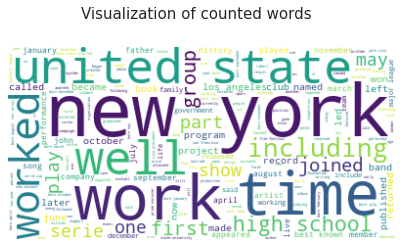

In [ ]:
plt.suptitle('Visualization of counted words', fontsize=15)
plt.rcParams["figure.figsize"] = (10, 6)
wordcloud = WordCloud(background_color="white")
plt.imshow(wordcloud.generate(' '.join(data['text'])), interpolation='bilinear')
plt.axis("off")
plt.show()

<a name="cell-id1.1"></a>
### **2.1.** Compute Word Count for the corpus

Veri kümesinden kelime sayılarını (word counts) bulalım.

In [ ]:
cnt_vectorizer = CountVectorizer(stop_words='english')
count_matrix = cnt_vectorizer.fit_transform(data.text.values)
features = cnt_vectorizer.get_feature_names()

Elton John makalesinde 'john', 'award' ve 'billboard' en çok bahsi geçen 3 kelimedir.

In [ ]:
elton_john_counter = pd.Series(
    count_matrix.getrow(data[data['name']=='Elton John'].index[0]).toarray().flatten(), 
    index = features).sort_values(ascending=False)

fig = px.bar(pd.DataFrame({'Words': elton_john_counter[:30].index, 
                           'Occurrences': elton_john_counter[:30].values}), 
                           x="Words", y="Occurrences")
fig.update_layout(
    title="Elton John Wikipedia Article Word Counts",
    title_font_size=18,
    width=600,
    height=400)

fig.show()

<a name="cell-id1.2"></a>
### **2.2.** Compute TF-IDF for the corpus


​
#### What is TF-IDF?
- It's used in document retrieval and text mining.
- TF-IDF concept  can be used to create a profile of an article.
- It stands for term frecuency times inverse document frecuency $TF_{IDF} = TF*IDF$. When we multiply this two together. We get a weight. And that weight is assigned to a term. 
- Term frecuency(TF): Number of ocurrences of the term in the document. When we talk about term frecuency we could mean how ofter does  the term , lets say 'car accident,' appear on the article. But we also could mean how often  the tag 'car accident' get applied to the article. 
- Inverse Document Frecuency (IDF): How few documents contains this term $ \rightarrow log \frac{ \#documents}{ \# documents\quad with\quad  term} $ Intuitively refers how rare for a document to have this term or for a tag to be applied to the article. $\rightarrow$ the higher the number of documents that have this term , the lower the IDF value is. We dont care much about a term if appears everywher, but we care a lot about a term if it is rare. 
​
$$W_{t_d} =   (1 + log   tf _{t_d}) log( \frac{N}{df_t}) $$
In other words, tf-idft,d assigns to term $t$ a weight in document $d$ that is
1. highest when $t$ occurs many times within a small number of documents. 
2. lower when the term occurs fewer times in a document,or occurs in many documents. 
3. lowest when the term occurs in virtually all documents.
​
#### Final ranking of documents for a query
 $$ Score(q,d) =\sum_ {t\in q\cap d}  tf.idf_{t,d}   $$
 
 Where $q \: and \:   d$ are two different documents .The score of a document $d$ is the sum, over all query terms, of the number of times each of the query terms occurs in  $d$. We can refine this idea so that we add up not the number of occurrences of each query term $t$ in  $d$, but instead the tf-idf weight of each term in $d$. In this exact case we usee knn for clustering ,this is one apporach you could use we only the $tf-idf$ matix, there is another approach as cosine similarity to make queries. If you would like to read more about it check the references, particularly the one called ' Scoring, term weighting and the vector space model'.
​
#### Pros
-  Automatic demotion of stopword.
-  Promotes core words over incidental ones.
​
#### Cons
- If core term doens't appear much.
- Poor searches (Better techniques like search completion and query completion).
. it doenst recognize significance in documents (Titles, headings).
- Phrases and n-grams (Scikit Tfidfvectorizer has an option to take under consideration this scenario).
​
#### Variants on TF-IDF
- 0/1 Boolean frecuencies (occurs above threshold).
- Logarithmic frecuencies (tf +1).
- Normalized frecuencies (divide by document length).

TfidfVectorizer: Converts a collection of raw documents to a matrix of TF-IDF features.

min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.

max_df: When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold.
Apply this vectorizer to the full dataset to create normalized vectors

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, sublinear_tf=True, use_idf =True, stop_words = 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data.text.values)
features = tfidf_vectorizer.get_feature_names()

Elton John makalesinde 'furnish', 'elton' ve 'billboard' en yüksek 3 TF-ID değerlerine sahip kelimelerdir.

In [ ]:
elton_john_tfidf = pd.Series(
    tfidf_matrix.getrow(data[data['name']=='Elton John'].index[0]).toarray().flatten(),
    index = features).sort_values(ascending=False)

fig = px.bar(pd.DataFrame({'Words': elton_john_tfidf[:30].index, 
                           'TF-IDF': elton_john_tfidf[:30].values}), 
                           x="Words", y="TF-IDF")
fig.update_layout(
    title="Elton John Wikipedia Article Word TF-IDF Values",
    title_font_size=18,
    width=600,
    height=400)

fig.show()

Using the cosine distance, as a measure of similarity between vectors, let's compute the distance between Elton John's article and those of two other famous singers, Victoria Beckham and Paul McCartney. We can observe that Elton John is more similar to Paul McCartney than to Victoria Beckham, which makes sense, since they both are of similar age, british and have more similar music style than Elton John and Victoria Beckham.

In [ ]:
print('Cosine distance between the articles on Victoria Beckham and Elton John: {:.2f}.'.format(
    metrics.pairwise.cosine_distances(tfidf_matrix.getrow(data[data['name']=='Victoria Beckham'].index[0]),
                                      tfidf_matrix.getrow(data[data['name']=='Elton John'].index[0]))[0,0]
))

Cosine distance between the articles on Victoria Beckham and Elton John: 0.95.


In [ ]:
print('Cosine distance between the articles on Paul McCartney and Elton John: {:.2f}.'.format(
    metrics.pairwise.cosine_distances(tfidf_matrix.getrow(data[data['name']=='Paul McCartney'].index[0]),
                                      tfidf_matrix.getrow(data[data['name']=='Elton John'].index[0]))[0,0]
))

Cosine distance between the articles on Paul McCartney and Elton John: 0.80.


<a name="cell-id2"></a>
## **3.** K-NEAREST NEIGHBOURS Clustering <a name="cell-id1"></a>




The general idea is you have a bunch of training points and each of these points has a bunch of features $x_1,x_2,x_3,,,,,x_n$ Where each of them has a known classification. 

**Types of classification**
- Boolean. Example: $\rightarrow$ if belongs to a class or not
- Discrete. Example $\rightarrow$You have classes A, B and C to classify the point.
- Continuous: Examble $\rightarrow$Predict the height of a basketball player

The objective is given some training data with known feautures $(\bar x)$ and known classification $(y)$ produce a rule for classsifying new points with **known** features and **unknown** classfication.


### How does it work?

__*First Step*__ : Define K.

__*Second Step*__: Compute Distance

__*Third Step*__: Sort the distances

__*Fourth Step*__:  Take k nearest neighbours

__*Fifth Step*__:  Apply simple majority

_____



**Cross-validation**: It's a way of figuring out if you have such a good parameter in this case we will use this to find out which k is the best for our model. To achieve this we have to set aside some part of the training data. Choose a value of k using the remaining data , then test whether the data that we set aside get classified correctly

**Choosing k:**
- Classification is sensitive to the correct selection of k.
 - if k is too small $\rightarrow $ overfitting $\rightarrow$ algorithm performs too good on the training set, compared to its true performance on unseen test data
 - small k? $\rightarrow$ less stable, influenced by noise
 - larger k? $\rightarrow$ less precise, higher bias. 
 
 One way of finding out which k is the best. It's using the elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above), and for each value of k calculate the sum of squared errors (SSE). SSE is the sum of the squared differences between each observation and its group's mean. It can be used as a measure of variation within a cluster. If all cases within a cluster are identical the SSE would then be equal to 0. $$ SSE= \sum_{i=1}^n (x_i -\bar x)^2$$
Then, plot a line chart of the SSE for each value of k. If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. The idea is that we want a small SSE, but that the SSE tends to decrease toward 0 as we increase k (the SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster). So our goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.


**Distance metrics**:

- *Euclidean distance*: $D(\bar u,\bar v)$ where a and b could be of any dimension . $ \sqrt{ \sum_ {i=1}^n (u_i-v_i)^2}$
- *Manhattan distance*: $D(\bar u, \bar v): \sum_ {i=1}^n | u_i - v_i|$. A case where you might wanna use that is when you classify people based on which groceries store they live nearer, so you dont care which grocery store has the shortest euclidean distance, because they have to go along the streeets
- *Hamming distance*: Its useful when you want to  compare simbolic things. Because it just look whether the vector components are the same or not. $D(\bar u, \bar v) = \sum_ {i=1}^n \neq( u_i,  v_I)$ . Let's say we have two toys with the next properties:
$\bar u=(0,red,soft)\quad  and \quad \bar v=(0,blue,soft)$. How many components are different? Only one. So our hamming distance will be one.
- *Cosine distance*: Which is gonna look at the angle between two points. Cosine similatiry is a similarity metric so the cosine of a smaller angle is actually a bigger number so we are just going to negate it, $1- cosine\quad similarity$ so effectively larger angles mean larger distance. So the formula is $1-cos(\alpha)$  where $cos(\alpha) =\frac {\bar u \bar v}{|| \bar u|| ||\bar v ||} $ A case where you might wanna use this . its when you care more about the ratio between the features than the actual quantities, so if you are looking at recipes  and you dont care how much sugar or flour but only the proportion between them , you would like to look at the angles between the recipes rather than the actual  euclidean distance between them.
- *Transform to polar coordinates*: The basic idea is if you have some data that looks concentric then you can just transform it in order to be easiert to work with the data
- *Minkowski distance* : $ D(\bar u,\bar v)$ =  $ (\sum_{i=1}^n |p_i -q_i|^p)^{\frac{1}{p}} $ for $p = 1 \: or \:  p = 2, $ the Minkowski metric becomes equal to the Manhattan and Euclidean metrics respectively. Where $p$ is a parameter, n is the number of dimensions (attributes) and $p_i$ and $q_i$ are, respectively, the ith attributes (components) or data objects $p$ and $q$.


You could also use cross validation to pick which distance fits better in your model.
If you have data which is not numerical and you want to use cosine similarity or euclidean distance you should convert all features of the instances into numerical values.

**Pros**
 - simple to implement and use
 -  robust to noisy data by averaging k-nearest neighbours  
 - KNN classification is based solely on local information   
 - the decision boundaries can be of arbitrary shapes
 
**Cons**
- curse of dimensionality:distance can be dominated by irrelevant attributes
- O(n)for each instance to be classified
- More expensive to classify a new instance than with a model


<a name="cell-id2.1"></a>
### **3.1.** Word Counter K-NN

In [ ]:
word_cnt_knn = NearestNeighbors(n_neighbors=20, metric='cosine')
word_cnt_knn.fit(count_matrix)

NearestNeighbors(metric='cosine', n_neighbors=20)

<a name="cell-id2.2"></a>
###**3.2.** TF-IDF K-NN

In [ ]:
tfidf_knn = NearestNeighbors(n_neighbors=20, metric='cosine')
tfidf_knn.fit(tfidf_matrix)

NearestNeighbors(metric='cosine', n_neighbors=20)

<a name="cell-id2.3"></a>
### **3.3.** Analysis

In [ ]:
closest_friends = word_cnt_knn.kneighbors(
    count_matrix.getrow(data[data['name']=='Elton John'].index[0]), 
    return_distance=True)
names_index = closest_friends[1][0]
names = [data.iloc[row]['name'] for row in names_index]
distances = closest_friends[0][0]

if distances[0]==0.0: distances, names = np.delete(distances, 0), np.delete(names, 0) 

fig = px.bar(pd.DataFrame({'Distances': distances,
                           'Neighbours':names }), 
             x="Distances", y="Neighbours",
             orientation='h')
fig.update_layout(
    title="Closest Neighbours Model to Elton John with Word Count",
    title_font_size=18,
    width=600,
    height=400,
    yaxis = dict(
        tickmode = 'linear'
    ))

fig.show()

The 2 closest neighboring articles for the Elton John article (i.e. 2 article recommendations using word count knn model)

In [ ]:
data[data['name']==names[1]]['text'].values[0]

'roderick david rod stewart cbe born 10 january 1945 is a british rock singersongwriter born and raised in london he is of english and scottish ancestry stewart is one of the bestselling music artists of all time having sold over 100 million records worldwidehe has had six consecutive number one albums in the uk and his tally of 62 uk hit singles includes 31 that reached the top 10 six of which gained the number one position he has had 16 top ten singles in the us with four reaching number one on the billboard hot 100 in 2007 he received a cbe at buckingham palace for services to musicwith his distinctive raspy singing voice stewart came to prominence in the late 1960s and early 1970s with the jeff beck group and then with faces though his music career had begun in 1962 when he took up busking with a harmonica in october 1963 he joined the dimensions as a harmonica player and parttime vocalist then in 1964 he joined long john baldry and the all stars later in august 1964 he also signed

In [ ]:
data[data['name']==names[2]]['text'].values[0]

'philip david charles phil collins lvo born 30 january 1951 is an english singer songwriter multiinstrumentalist and actor he gained fame as both drummer and lead vocalist for the rock group genesis and he gained worldwide fame as a solo artist collins is one of the most successful songwriters and performers of all time singing the lead vocals on dozens of hit albums and singles in the united kingdom and the united states between 1976 and 2010 either as a solo artist or with genesis his solo singles sometimes dealing with lost love and often featuring his distinctive gated reverb drum sound ranged from the atmospheric in the air tonight dancerock of sussudio pianodriven power ballad against all odds to the political and religious connotations of another day in paradise allmusic has described collins as one of the most successful pop and adult contemporary singers of the 80s and beyondcollins joined genesis in 1970 as the groups drummer and became their lead vocalist in 1975 following t

In [ ]:
closest_friends = tfidf_knn.kneighbors(
    tfidf_matrix.getrow(data[data['name']=='Elton John'].index[0]), 
    return_distance=True)
names_index = closest_friends[1][0]
names = [data.iloc[row]['name'] for row in names_index]
distances = closest_friends[0][0]

if distances[0]==0.0: distances, names = np.delete(distances, 0), np.delete(names, 0) 

fig = px.bar(pd.DataFrame({'Distances': distances,
                           'Neighbours':names }), 
             x="Distances", y="Neighbours",
             orientation='h')
fig.update_layout(
    title="Closest Neighbours to Elton John with TF-IDF Model",
    title_font_size=18,
    width=600,
    height=400,yaxis = dict(
        tickmode = 'linear'
    ))

fig.show()

The 2 closest neighboring articles for the Elton John article (i.e. 2 article recommendations using tf-idf knn model)

In [ ]:
data[data['name']==names[0]]['text'].values[0]

'philip david charles phil collins lvo born 30 january 1951 is an english singer songwriter multiinstrumentalist and actor he gained fame as both drummer and lead vocalist for the rock group genesis and he gained worldwide fame as a solo artist collins is one of the most successful songwriters and performers of all time singing the lead vocals on dozens of hit albums and singles in the united kingdom and the united states between 1976 and 2010 either as a solo artist or with genesis his solo singles sometimes dealing with lost love and often featuring his distinctive gated reverb drum sound ranged from the atmospheric in the air tonight dancerock of sussudio pianodriven power ballad against all odds to the political and religious connotations of another day in paradise allmusic has described collins as one of the most successful pop and adult contemporary singers of the 80s and beyondcollins joined genesis in 1970 as the groups drummer and became their lead vocalist in 1975 following t

In [ ]:
data[data['name']==names[1]]['text'].values[0]

'gordon matthew thomas sumner cbe born 2 october 1951 known on stage as sting is an english musician singersongwriter multiinstrumentalist activist actor and philanthropist he was principal songwriter lead singer and bassist for the new wave rock band the police from 1977 to 1983 before launching a solo careerhe has included rock jazz reggae classical newage and worldbeat in his music as a solo musician and a member of the police he received 16 grammy awards his first for best rock instrumental in 1980 three brit awards including best british male in 1994 and outstanding contribution in 2002 a golden globe award an emmy award and three academy award nominations for best original song he was inducted into the songwriters hall of fame in 2002 and the rock and roll hall of fame as a member of police in 2003 in 2000 he received a star on the hollywood walk of fame for recording in 2003 sting received a cbe from elizabeth ii at buckingham palace for services to music and was made a kennedy 

In [ ]:
closest_friends = word_cnt_knn.kneighbors(
    count_matrix.getrow(data[data['name']=='Victoria Beckham'].index[0]),
    return_distance=True)
names_index = closest_friends[1][0]
names = [data.iloc[row]['name'] for row in names_index]
distances = closest_friends[0][0]

if distances[0]==0.0: distances, names = np.delete(distances, 0), np.delete(names, 0) 

fig = px.bar(pd.DataFrame({'Distances': distances,
                           'Neighbours':names }), 
             x="Distances", y="Neighbours",
             orientation='h')
fig.update_layout(
    title="Closest Neighbours to Victoria Beckham with Word Count Model",
    title_font_size=18,
    width=600,
    height=400,yaxis = dict(
        tickmode = 'linear'
    ))

fig.show()

The 2 closest neighboring articles for the Victoria Beckham article (i.e. 2 article recommendations using word count knn model)

In [ ]:
data[data['name']==names[0]]['text'].values[0]

'yuliya polishchuk is a londonbased fashion designer born in ukraine her signature is evident in the sophisticated elegant and incredibly detailed clothes for young original and unique ladies a strong educational background gained at leading universities in london as well as work experience in the uk fashion industry led yuliya to launch missu in 2012 her first label of tender fashion clothes available among the new generation of brand trendsetters now no 1 choice for new feminine couture very often women are hiding the real i and are afraid to let the world know about it im trying to create things with a real identity and elegance the designer explained during an interviewfollowing this slogan in march 2013 yuliya polishchuk has presented a new fashion line of exquisite evening dresses under her own name which has been recognized by the audience and fashion critics in ukraine a woman from yuliya polishchuk is sophisticated and elegant her gentle heart can be seen only by true connoiss

In [ ]:
data[data['name']==names[1]]['text'].values[0]

'zurain zaheen imam born january 7 1968 chittagong is a uspakistani print and broadcast fashion journalistimams formative years were spent in england his family home was in richmond surrey and he attended tower house school in sheen before he attended boarding school at holmewood house in tunbridge wells kent from 1977 till 1981 in 1981 his family moved back to pakistan and he attended cas from 1982 till 1987 from whence he attended portland state university where he majored in english with a minor in political science and where he was a star reporter for the college newspaper the vanguardafter receiving his ba degree he began a masters program online in media studies strategic planning and magazine development from new york university which he completed in the summer of 2006imam now lives in karachi he has been described as a leading and influential fashion journalist deemed one of the 50 most important people in entertainment and one of the 100 most memorable people in fashion by div

In [ ]:
closest_friends = tfidf_knn.kneighbors(
    tfidf_matrix.getrow(data[data['name']=='Victoria Beckham'].index[0]),
    return_distance=True)
names_index = closest_friends[1][0]
names = [data.iloc[row]['name'] for row in names_index]
distances = closest_friends[0][0]

if distances[0]==0.0: distances, names = np.delete(distances, 0), np.delete(names, 0) 

fig = px.bar(pd.DataFrame({'Distances': distances,
                           'Neighbours':names }), 
             x="Distances", y="Neighbours",
             orientation='h')
fig.update_layout(
    title="Closest Neighbours to Victoria Beckham with TF-IDF Model",
    title_font_size=18,
    width=600,
    height=400,yaxis = dict(
        tickmode = 'linear'
    ))

fig.show()

The 2 closest neighboring articles for the Elton John article (i.e. 2 article recommendations using tf-idf knn model)

In [ ]:
data[data['name']==names[0]]['text'].values[0]

'david robert joseph beckham obe bkm born 2 may 1975 is an english former professional footballer he has played for manchester united preston north end real madrid milan la galaxy paris saintgermain and the england national team for which he holds the appearance record for an outfield player he was the first english player to win league titles in four countries england spain the united states and france he announced his retirement at the end of the 201213 season and on 18 may 2013 played the final game of his 20year careerbeckhams professional career began with manchester united where he made his firstteam debut in 1992 aged 17 with united beckham won the premier league title six times the fa cup twice and the uefa champions league in 1999 he then played four seasons with real madrid winning the la liga championship in his final season with the club in july 2007 beckham signed a fiveyear contract with major league soccer club la galaxy while a galaxy player he spent two loan spells in 

In [ ]:
data[data['name']==names[1]]['text'].values[0]

'melanie janine brown born 29 may 1975 better known as mel b or melanie b is a british recording artist songwriter dancer actress author television presenter talent competition judge and model brown rose to fame as a member of the girl group the spice girls in which she was known as scary spice she is known as mel b to distinguish her from her spice girls bandmate melanie cthe spice girls signed to virgin records and in 1996 they released their debut single wannabe which hit number one in more than 30 countries and helped establish the group as a global phenomenon it was followed by their debut album spice which has sold more than 28 million copies worldwide becoming the bestselling album by a female group in music history the bands second album spiceworld went on to sell over 20 million copies worldwide as of 2013 the spice girls have sold over 100 million albums worldwide making them the biggest selling female group in history and also one of the bestselling music artists in the worl

<a name="cell-id3"></a>
## **4.** Discussion

TF-IDF modeli sorgulanan kişiye daha ilintili öneriler sunarken, word counter modeli sorgulanan kişiye daha benzer öznitelikte olan kişileri önermektedir.

#**Referanslar**

*   [People Wikipedia](https://www.kaggle.com/sameersmahajan/working-with-people-wikipedia-data)
*   [People Wikipedia 2](https://www.kaggle.com/meuge672/tf-idf-and-knn-in-people-wikipedia-dataset)

*   [Scoring, term weighting and the vector space model](https://nlp.stanford.edu/IR-book/pdf/06vect.pdf)
*   [Coursera tfidf and content filtering](https://www.coursera.org/learn/recommender-systems-introduction/lecture/I4aJD/tfidf-and-content-filtering)
*   [MIT Artificial Intelligence](https://www.youtube.com/watch?v=4W4qxI2W00k&index=6&list=PLxymR0ZPfMmV-vGtvhvTeWHIcnh-bTjDI)
*   [Elbow method](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)